## Pipeline do modelo principal proposto: será incorporado ao MakeModel no código modularizado de produção

In [1]:
import pandas as pd
import numpy as np
from typing import Dict, Tuple, List

from sklearn.model_selection import TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from james_stein_custom import _JamesSteinEncoder
import xgboost as xgb

import optuna
import shap

import category_encoders as ce

from sklearn.metrics import roc_auc_score
from scipy import stats
import matplotlib.pyplot as plt

def calcular_ks_scipy(y_true: np.ndarray, y_pred_proba: np.ndarray) -> float:
    prob_bads = y_pred_proba[y_true == 1]
    prob_goods = y_pred_proba[y_true == 0]
    if len(prob_bads) == 0 or len(prob_goods) == 0: return 0.0
    ks_statistic, p_value = stats.ks_2samp(prob_bads, prob_goods)
    return ks_statistic

def weighted_logloss_obj(y_pred_raw: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[np.ndarray, np.ndarray]:
    y_true = dtrain.get_label()
    costs = dtrain.get_weight() 
    p = 1.0 / (1.0 + np.exp(-y_pred_raw))
    grad = costs * (p - y_true)
    hess = costs * p * (1.0 - p)
    return grad, hess

def ks_auc_feval(y_pred_raw: np.ndarray, dtrain: xgb.DMatrix) -> List[Tuple[str, float]]:
    y_true = dtrain.get_label()
    p = 1.0 / (1.0 + np.exp(-y_pred_raw))
    auc = roc_auc_score(y_true, p)
    ks = calcular_ks_scipy(y_true, p)
    return [('auc', auc), ('ks', ks)]

try:
    treino_df = pd.read_csv("../data/dev/train.csv", index_col=0)
    validacao_df = pd.read_csv("../data/dev/val.csv", index_col=0)
    teste_oot_df = pd.read_csv("../data/dev/test.csv", index_col=0)

    dev_df = pd.concat([treino_df, validacao_df], ignore_index=True)
    
    TARGET = 'target'
    COST_FN_COL = 'custo_fn'
    COST_FP_COL = 'custo_fp'
    
    FEATURES = [col for col in dev_df.columns if col not in [
        TARGET, 'data_originacao', 'id_contrato', COST_FN_COL, COST_FP_COL
    ]]

    X_dev = dev_df[FEATURES]
    y_dev = dev_df[TARGET]
    
    costs_dev = np.where(y_dev == 1, dev_df[COST_FN_COL], dev_df[COST_FP_COL])

    X_oot = teste_oot_df[FEATURES]
    y_oot = teste_oot_df[TARGET]
    
except FileNotFoundError as e:
    print(f"Problema com os dados: {e}")
    exit()

js_cols = ['estado', 'id_varejo']
ohe_cols = ['tipo_cliente']
target_enc_cols = [col for col in FEATURES if col.endswith('_bin')]

preprocessor = ColumnTransformer(
    transformers=[
        ('james_stein', _JamesSteinEncoder(min_samples = 200), js_cols),
        ('one_hot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, min_frequency=5), ohe_cols),
        ('target_encoder', ce.TargetEncoder(), target_enc_cols)
    ],
    remainder='passthrough'
)

def objective(trial: optuna.Trial) -> float:
    params = {
        'objective': 'binary:logistic',
        'booster': 'gbtree', 'n_jobs': -1,
        'eta': trial.suggest_float('eta', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 100, log=True),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
    }
    
    tscv = TimeSeriesSplit(n_splits=5)
    fold_auc_scores = [] 

    for train_index, val_index in tscv.split(X_dev):
        X_train_fold, X_val_fold = X_dev.iloc[train_index], X_dev.iloc[val_index]
        y_train_fold, y_val_fold = y_dev.iloc[train_index], y_dev.iloc[val_index]

        # Seleciona a fatia correta dos custos para o fold de treino
        costs_train_fold = costs_dev[train_index]
        
        X_train_processed = preprocessor.fit_transform(X_train_fold, y_train_fold)
        X_val_processed = preprocessor.transform(X_val_fold)
        
        # Aqui entra o peso por instância na DMatrix
        dtrain = xgb.DMatrix(X_train_processed, label=y_train_fold, weight=costs_train_fold)
        dval = xgb.DMatrix(X_val_processed, label=y_val_fold)
        
        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=1000,
            evals=[(dval, 'validation')],
            obj=weighted_logloss_obj,
            custom_metric=ks_auc_feval,
            callbacks=[xgb.callback.EarlyStopping(rounds=50, metric_name='auc', maximize=True)],
            verbose_eval=False
        )
        fold_auc_scores.append(model.best_score)

    return np.mean(fold_auc_scores)

study = optuna.create_study(direction='maximize')
study.optimize(
    objective, 
    n_trials=100,
    show_progress_bar=True 
)

print(f"Melhor valor de AUC na validação cruzada: {study.best_value:.4f}")
print("Melhores hiperparâmetros encontrados:")
print(study.best_params)
print("\n" + "="*80 + "\n")

best_params = study.best_params
best_params.update({'objective': 'binary:logistic', 'booster': 'gbtree', 'n_jobs': -1})

X_dev_processed = preprocessor.fit_transform(X_dev, y_dev)
X_oot_processed = preprocessor.transform(X_oot)

dtrain_final = xgb.DMatrix(X_dev_processed, label=y_dev, weight=costs_dev)
doot = xgb.DMatrix(X_oot_processed, label=y_oot)

final_model = xgb.train(
    params=best_params,
    dtrain=dtrain_final,
    num_boost_round=500, 
    obj=weighted_logloss_obj,
    verbose_eval=100
)

y_oot_pred_proba_tuned = final_model.predict(doot)

auc_oot_tuned = roc_auc_score(y_oot, y_oot_pred_proba_tuned)
ks_oot_tuned = calcular_ks_scipy(y_oot.values, y_oot_pred_proba_tuned)

print("\n" + "---" * 10 + " RESULTADO FINAL (OOT) - XGBoost Otimizado " + "---" * 10)
print(f">> Performance no Teste Out-of-Time: AUC = {auc_oot_tuned:.4f}, KS = {ks_oot_tuned:.4f}")
print("---" * 27)

[I 2025-06-24 10:01:25,112] A new study created in memory with name: no-name-ad47144c-6a14-4ef8-9357-fa3ffe53efd8


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-06-24 10:01:32,380] Trial 0 finished with value: 0.6337482000000001 and parameters: {'eta': 0.018303811692926185, 'max_depth': 7, 'subsample': 0.7193219854388013, 'colsample_bytree': 0.6137265050119748, 'min_child_weight': 45.236318060720514, 'lambda': 0.030883012467819153, 'alpha': 7.973715845308389e-06}. Best is trial 0 with value: 0.6337482000000001.
[I 2025-06-24 10:01:40,976] Trial 1 finished with value: 0.6289696 and parameters: {'eta': 0.014312901485304338, 'max_depth': 10, 'subsample': 0.8035886471555136, 'colsample_bytree': 0.5186686691211465, 'min_child_weight': 7.873819452690583, 'lambda': 3.219614446780991e-08, 'alpha': 0.5019247201798354}. Best is trial 0 with value: 0.6337482000000001.
[I 2025-06-24 10:01:45,925] Trial 2 finished with value: 0.6268084 and parameters: {'eta': 0.06195847899855832, 'max_depth': 7, 'subsample': 0.7710882121156628, 'colsample_bytree': 0.559107660001198, 'min_child_weight': 4.0695970625129085, 'lambda': 0.000990671058948723, 'alpha': 7.

## SHAP

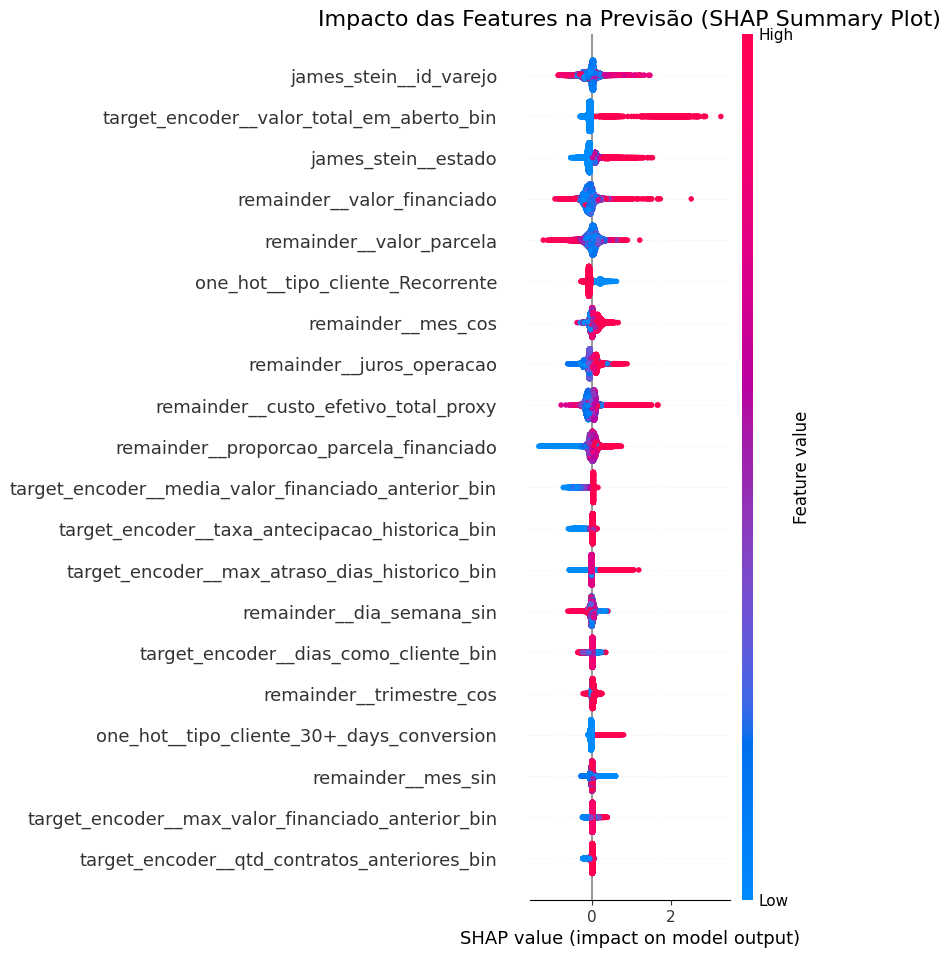

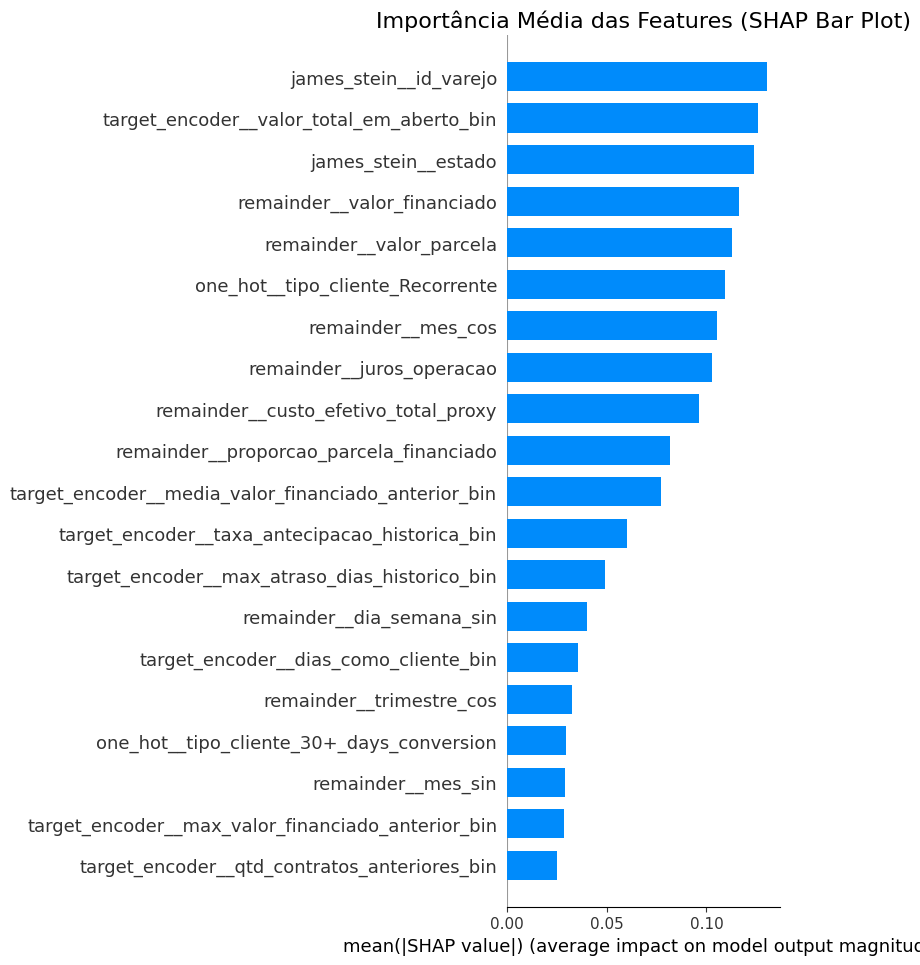

In [2]:
try:
    feature_names_transformed = preprocessor.get_feature_names_out()
except AttributeError:
    ohe_cols_new = preprocessor.named_transformers_['one_hot'].get_feature_names_out(ohe_cols)
    feature_names_transformed = list(js_cols) + list(ohe_cols_new) + list(target_enc_cols)
    
X_oot_processed_df = pd.DataFrame(X_oot_processed, columns=feature_names_transformed)

explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_oot_processed_df)

shap.summary_plot(shap_values, X_oot_processed_df, plot_type="dot", show=False)
plt.title("Impacto das Features na Previsão (SHAP Summary Plot)", fontsize=16)
plt.show()

shap.summary_plot(shap_values, X_oot_processed_df, plot_type="bar", show=False)
plt.title("Importância Média das Features (SHAP Bar Plot)", fontsize=16)
plt.show()